# Pràctica 4 - Profunditat de l'escena
### Pol Gràcia
### Miguel Esteban

In [1]:
import numpy as np    
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

In [2]:
path = ['Images/' + x  for x in os.listdir('Images/') if os.path.isdir('Images/'+x)]

### 1. Carregar i mostrar imatges d'una escena del dataset

In [3]:
def get_stereo_scene(scene_name, show = True):
    try:
        path_func = [x for x in path if scene_name in x][0]
    except:
        print('No path named', scene_name)
        exit 
    image_left = cv2.imread(path_func + '/view1.png')
    image_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY).astype(np.float64)

    image_right = cv2.imread(path_func + '/view5.png')
    image_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY).astype(np.float64)

    disparity_left = cv2.imread(path_func + '/disp1.png')
    disparity_left = cv2.cvtColor(disparity_left, cv2.COLOR_BGR2GRAY).astype(np.float64)

    mask_left = (disparity_left == 0).astype(np.uint8)

    if show:
        fig, ax = plt.subplots(2,2, figsize=(15,15))
        ax[0][0].title.set_text('Image left')
        ax[0][0].imshow(image_left, cmap = 'gray')
        ax[0][1].title.set_text('Image right')
        ax[0][1].imshow(image_right, cmap = 'gray')
        ax[1][0].title.set_text('Disparity left')
        ax[1][0].imshow(disparity_left, cmap = 'gray')
        ax[1][1].title.set_text('Mask left')
        ax[1][1].imshow(mask_left, cmap = 'gray')
    return image_left, image_right, disparity_left,mask_left

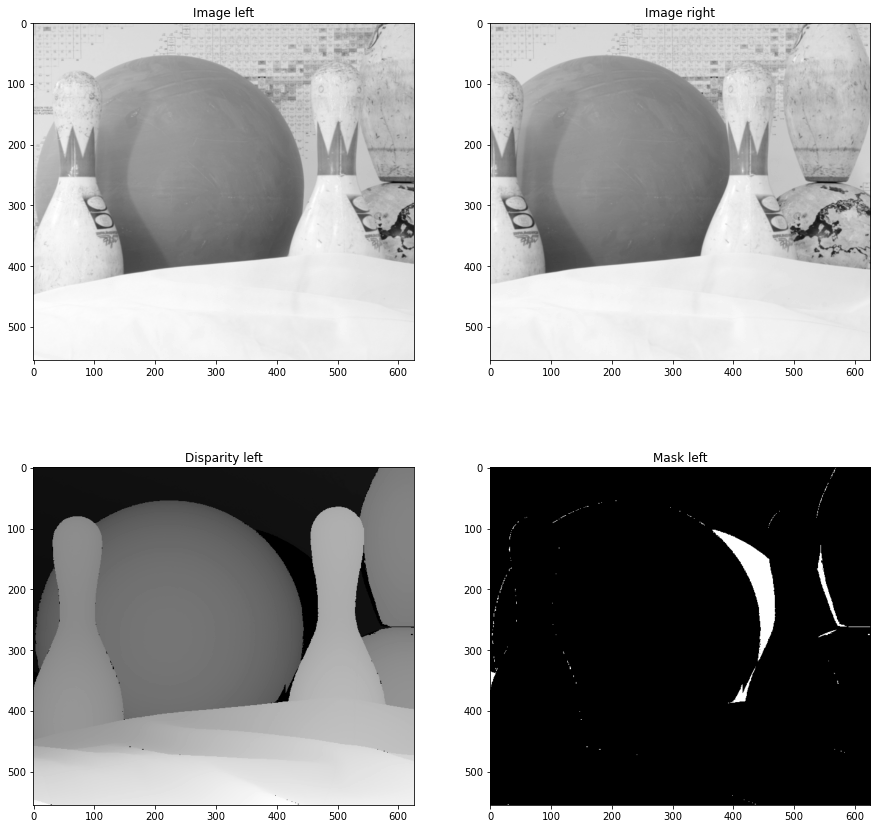

In [4]:
image_left, image_right, disparity_left, disparity_mask = get_stereo_scene('Bowling1')

### 2. Càlcul de la disparitat esquerra aplicant block matching 

In [5]:
def block_matching_distance_map(img_left, img_right, n, disp_max, prefilter=None):
    res = np.zeros((img_left.shape[0],img_left.shape[1], disp_max), dtype = np.float64)
    for d in range(disp_max):
        tmp = np.roll(img_right, d, axis = 1)
        tmp[:,:d] = 0
        dif = np.abs(img_left - tmp)
        kernel = np.ones((n,n)) / (n*n)
        res[:,:,d] = cv2.filter2D(dif, -1, kernel)
        
    return res

def values_from_arg(disparity, mapping):
    arr = np.zeros_like(disparity)
    for x in range(disparity.shape[0]):
        for y in range(disparity.shape[1]):
            arr[x,y] = mapping[x,y,disparity[x,y]]
    return arr

def result(gt, disp_m, show = True):
    disp = np.argmin(disp_m, axis = 2)
    if show:
        fig, ax = plt.subplots(1,3, figsize=(15,25))
        ax[0].title.set_text('GT')
        ax[0].imshow(gt, cmap = 'gray')
        ax[1].title.set_text('Disparitat')
        ax[1].imshow(disp, cmap = 'gray')
        ax[2].title.set_text('Diferència')
        ax[2].imshow(abs(gt-disp), cmap = 'gray')
    return disp

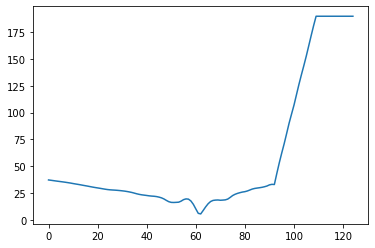

In [6]:
disp_map = block_matching_distance_map(image_left, image_right, 17, 125)
plt.plot(disp_map[172, 100, :])

In [7]:
x = disp_map[172,100,:]

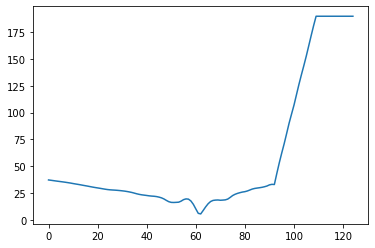

In [8]:
plt.plot(x)

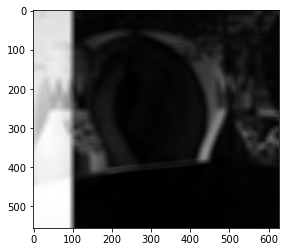

In [9]:
plt.imshow(disp_map[:,:,100], cmap = 'gray')

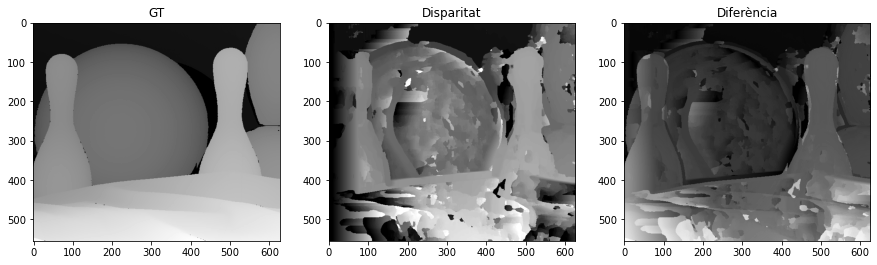

In [10]:
res = result(disparity_left, disp_map)

### 3. Mesura quantitativa del mètode implementat

In [11]:
def bad(thresh, gt, res, rpr = True):
    d = (abs(gt-res) > thresh).sum() / (gt.shape[0]*gt.shape[1]) * 100
    if rpr:
        print(f'Percentatge of bad pixels whose error is > {thresh} is {round(d,2)}')
    return d

def avgerr(gt, res, rpr = True):
    err = mean_absolute_error(gt, res)
    if rpr:
        print(f'Error absolut mitjà és {round(err,3)}')
    return err 

def rms(gt, res, rpr = True):
    err = mean_squared_error(gt, res, squared=False)
    if rpr:
        print(f'Root-mean-squared dispairity error is {round(err,3)}')
    return err 

def time_err(img_left, img_right, n, disp_max, prefilter = False, rpr = True):
    t0 = time.time()
    disp_map = block_matching_distance_map(img_left, img_right, n, disp_max,prefilter)
    np.argmin(disp_map, axis = 2)
    t1 = time.time()
    if rpr:
        print(f'Exec time {round(t1-t0,2)} s')
    return t1-t0

In [12]:
bad(0.5, disparity_left, res)
bad(5, disparity_left, res)
avgerr(disparity_left, res)
rms(disparity_left, res)
time_err(image_left, image_right, 3, 125)

Percentatge of bad pixels whose error is > 0.5 is 99.32
Percentatge of bad pixels whose error is > 5 is 98.03
Error absolut mitjà és 66.923
Root-mean-squared dispairity error is 78.684
Exec time 0.83 s


0.8317217826843262

### 4. Posar en correspondència la derivada 

In [13]:
def sobel(image):  
    x = cv2.Sobel(image, cv2.CV_64F,1,0, ksize = 3)
    return x 

In [14]:
def block_matching_distance_map(img_left, img_right, n, disp_max, prefilter = False):
    if prefilter:
        img_left = sobel(image_left)
        img_right = sobel(image_right)
    res = np.zeros((img_left.shape[0],img_left.shape[1], disp_max))
    
    for d in range(disp_max):
        tmp = np.roll(img_right, d, axis = 1)
        tmp[:,:d] = 255
        dif = np.abs(img_left - tmp)
        kernel = np.ones((n,n)) / (n*n)
        res[:,:,d] = cv2.filter2D(dif, -1, kernel)

    return res


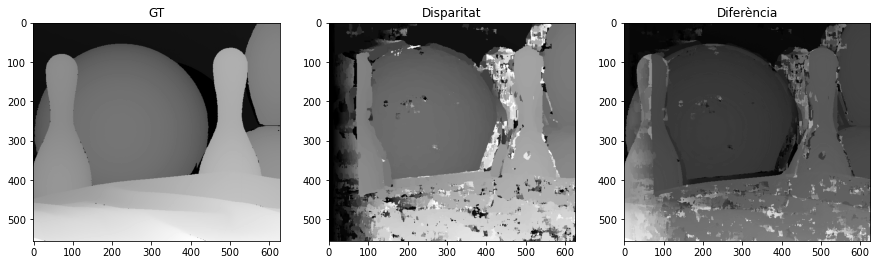

In [15]:
disp_map = block_matching_distance_map(image_left, image_right, 17, 125, prefilter = True)
res = result(disparity_left, disp_map)

In [16]:
bad(0.5, disparity_left, res)
bad(5, disparity_left, res)
avgerr(disparity_left, res)
rms(disparity_left, res)
time_err(image_left, image_right, 15, 125, prefilter=True)

Percentatge of bad pixels whose error is > 0.5 is 99.9
Percentatge of bad pixels whose error is > 5 is 98.77
Error absolut mitjà és 66.628
Root-mean-squared dispairity error is 75.401
Exec time 1.46 s


1.4605414867401123

### 5. Anàlisi de la mida del patró en el mapa de disparitat

Va pitjor on no hi ha textura o textures repetitives

In [17]:
def results_analysis(datasets, kernels = 27, prefilter = False, show = False):

    data = [[res for res in get_stereo_scene(dataset)] for dataset in datasets]

    # image_left, image_right, disparity_left, _ = get_stereo_scene(dataset)
    df = list()

    for (image_left, image_right, disparity_left, _), dataset in zip(data, datasets):
        d = {'kernel_size': [], 'error': [], 'type': [], 'dataset': []}

        for k in range(3, kernels, 2):
            disp_map = block_matching_distance_map(image_left, image_right, k, 125, prefilter = prefilter)
            res = result(disparity_left, disp_map, show = False)

            d['kernel_size'].append(k)
            d['kernel_size'].append(k)
            d['error'].append(rms(disparity_left, res, rpr = False)) #funcion llama rms
            d['type'].append('rmse')
            d['error'].append(avgerr(disparity_left, res, rpr = False)) #funcion retorna mae
            d['type'].append('mae')
            d['dataset'].append(dataset)
            d['dataset'].append(dataset)
        
        df.append(pd.DataFrame(d))
        
    data = pd.concat(df)

    if show:
        g = sns.FacetGrid(data, col='dataset', hue='type', palette='tab10', sharey=True, legend_out=True)
        g.map_dataframe(sns.lineplot, x="kernel_size", y="error")
        g.add_legend()

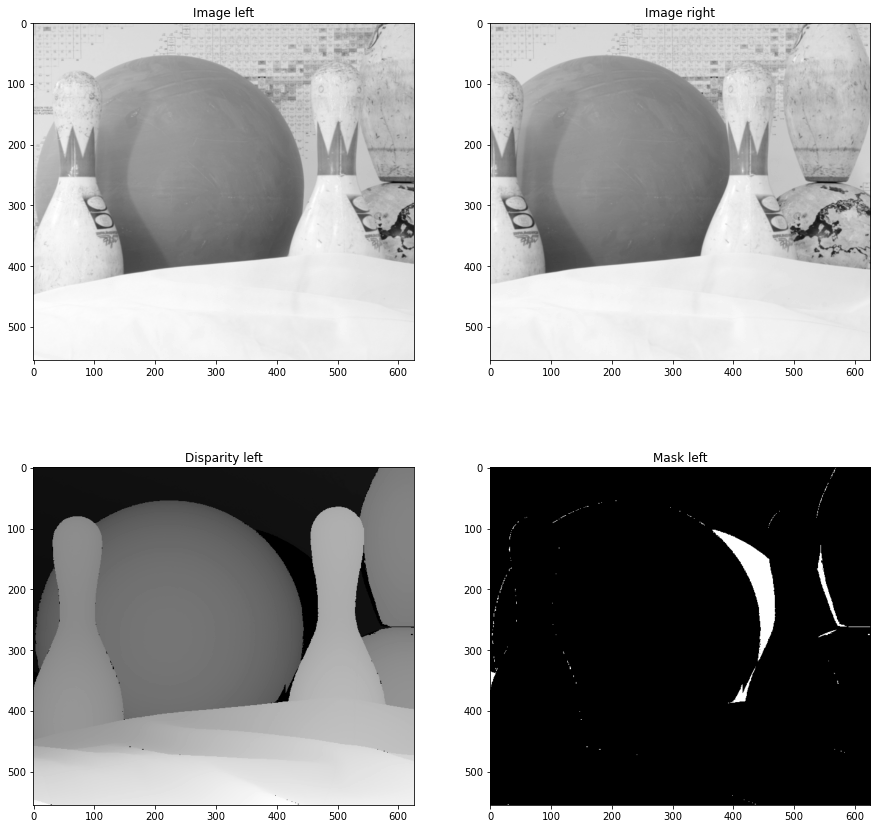

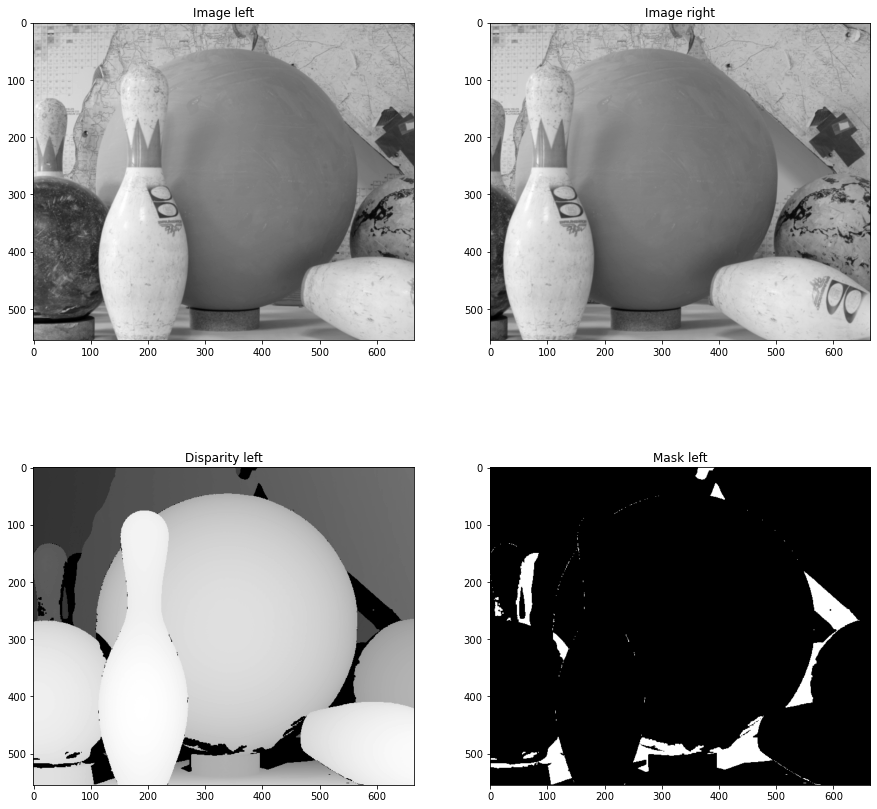

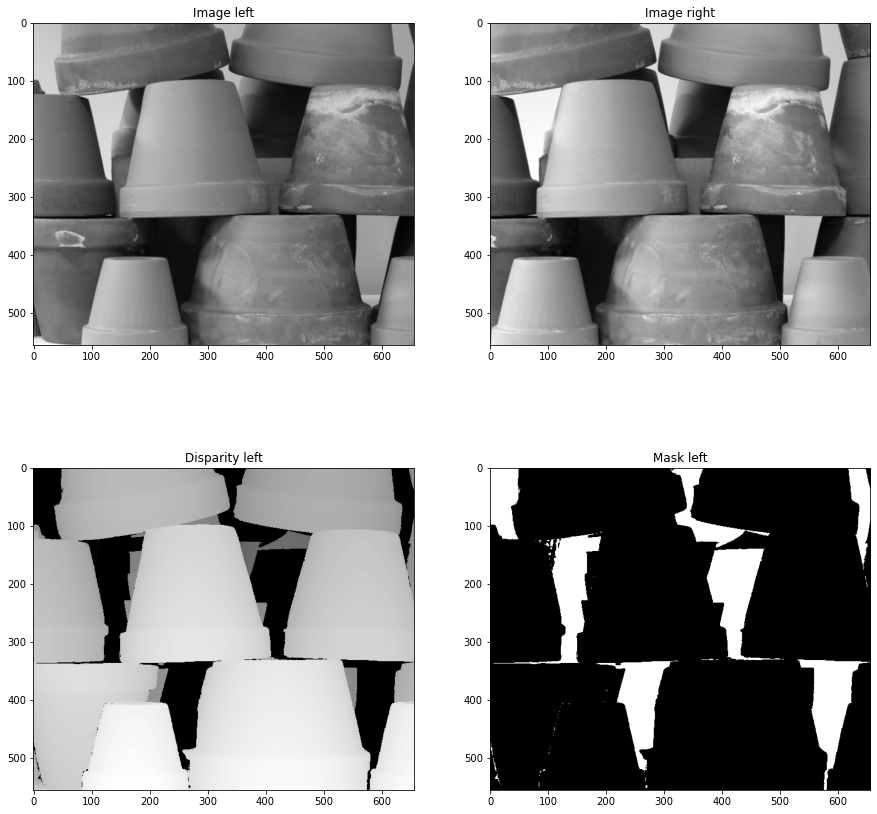

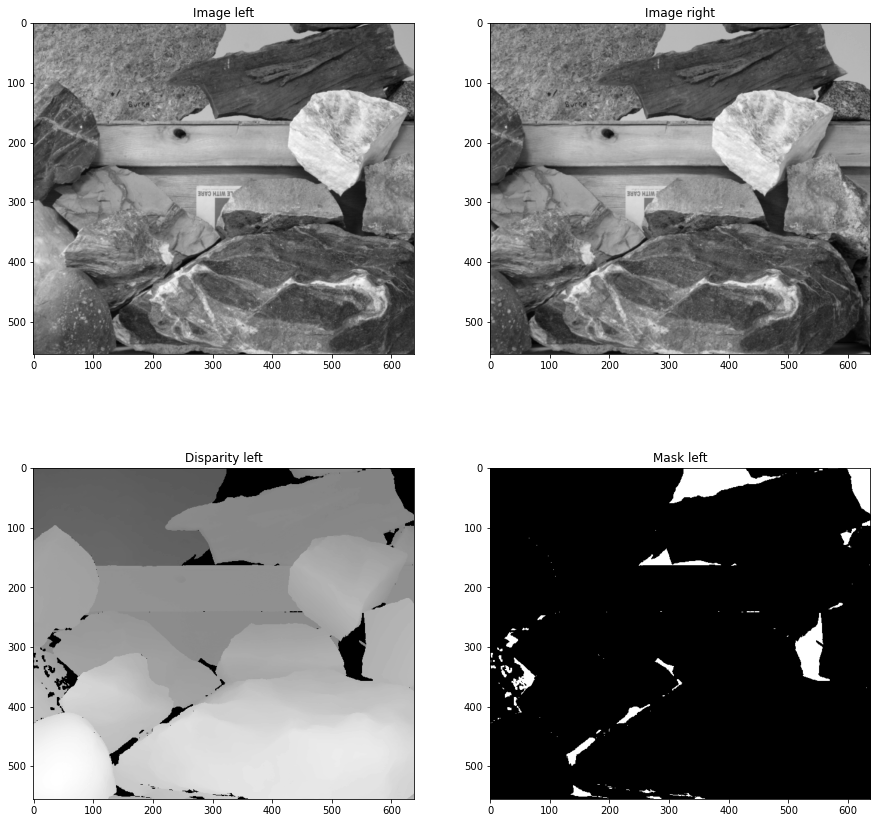

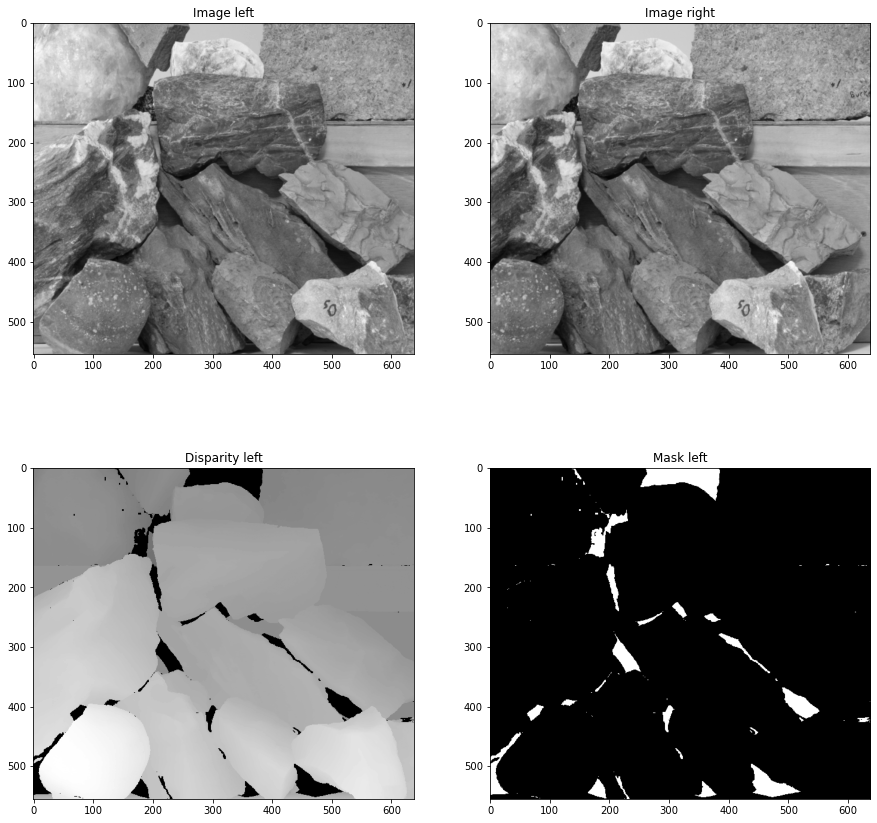

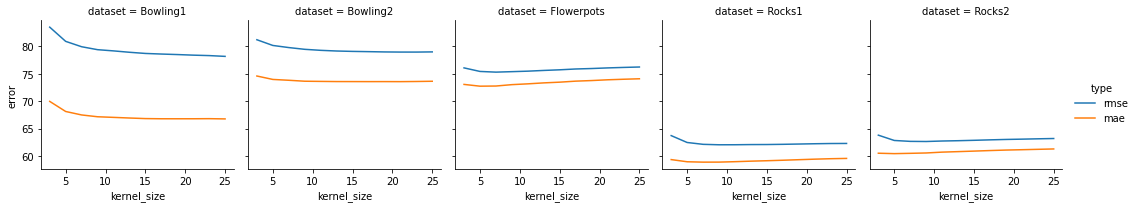

In [18]:
#testear con datasets = 'Bowling1', 'Bowling2', Flowerpots, Rocks1, Rocks2 (o algunos si quieres)
results_analysis(['Bowling1', 'Bowling2', 'Flowerpots', 'Rocks1', 'Rocks2'], kernels = 27, prefilter = False,  show = True)

Se puede apreciar como a partir de `kernel_size = 6`, la curva de error se estabiliza o empeora, por lo que aumentar el tamaño no implica mejorar el modelo.

> No se deben comparar las curvas entre ellas, ya que la dimensión no es la misma.

### Extra: Mesurar la confidència en el mapa de disparitat calculat

In [19]:
def confidence(disp_map, thresh = 5):
    res1 = np.argmin(disp_map, axis = 2)
    
    #busco segon argmin
    for x in range(disp_map.shape[0]):
        for y in range(disp_map.shape[1]):
            disp_map[x,y,res1[x,y]] = 1000

    res2 = np.argmin(disp_map, axis = 2)

    percentuals = (abs(res1 - res2) / ((res1 + res2) / 2)) * 100

    #disparitats fiables
    return (percentuals >= thresh).astype(np.float64)


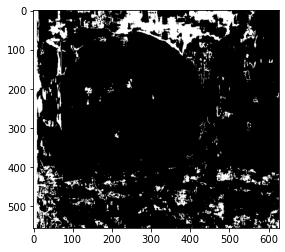

In [20]:
conf = confidence(disp_map, thresh = 99)
plt.imshow(conf, cmap = 'gray')

In [21]:
bad(0.5, disparity_left, conf)
bad(5, disparity_left, conf)
avgerr(disparity_left, conf)
rms(disparity_left, conf)

Percentatge of bad pixels whose error is > 0.5 is 97.92
Percentatge of bad pixels whose error is > 5 is 97.74
Error absolut mitjà és 115.38
Root-mean-squared dispairity error is 129.273


129.27299673178507